In [1]:
%matplotlib widget

import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")

from amftrack.util.sys import get_dirname
import pandas as pd
import ast
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.node_id import orient
import scipy.io as sio
import cv2
import imageio
import numpy as np
from skimage.filters import frangi
from skimage import filters
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
)
from amftrack.pipeline.paths.directory import (
    run_parallel,
    find_state,
    directory_scratch,
    directory_project,
)
from amftrack.plotutil import plot_t_tp1
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import optimize
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from pymatreader import read_mat
from amftrack.pipeline.functions.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
from random import choice

In [2]:
directory = directory_project
update_plate_info(directory)
all_folders = get_current_folders(directory)

In [3]:
plates = [102]
folders = all_folders.loc[
    (all_folders["/Analysis/skeleton_realigned_compressed.mat"])
    & (all_folders["Plate"].isin(plates))
]

In [4]:
index, row = choice(list(folders.iterrows()))

In [7]:
center, orth = find_center_orth(directory, row)

Directory  /projects/0/einf914/data/20210110_1950_Plate40/Analysis  already exists


In [8]:
itera = 1
kernel = np.ones((5, 5), np.uint8)
directory_name = row["folder"]
path_snap = directory + directory_name
skel_info = read_mat(path_snap + "/Analysis/skeleton_pruned_compressed.mat")
skel = skel_info["skeleton"]
skel = cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera)
im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]

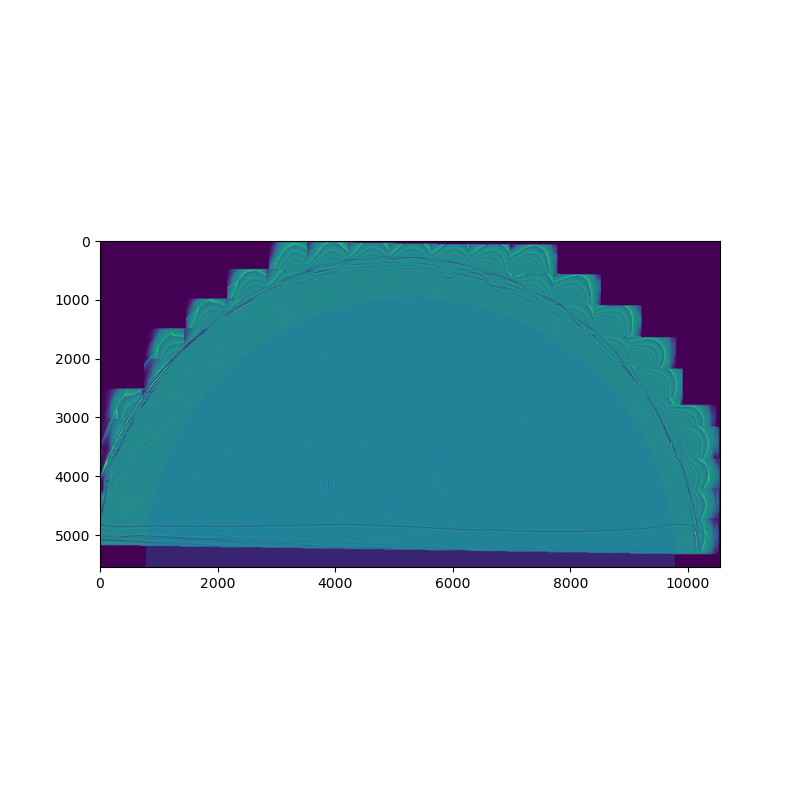

In [76]:
plt.close("all")
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(im)
circle2 = plt.Circle((xc_2, yc_2), 4500, alpha=0.3)
ax.add_patch(circle2)

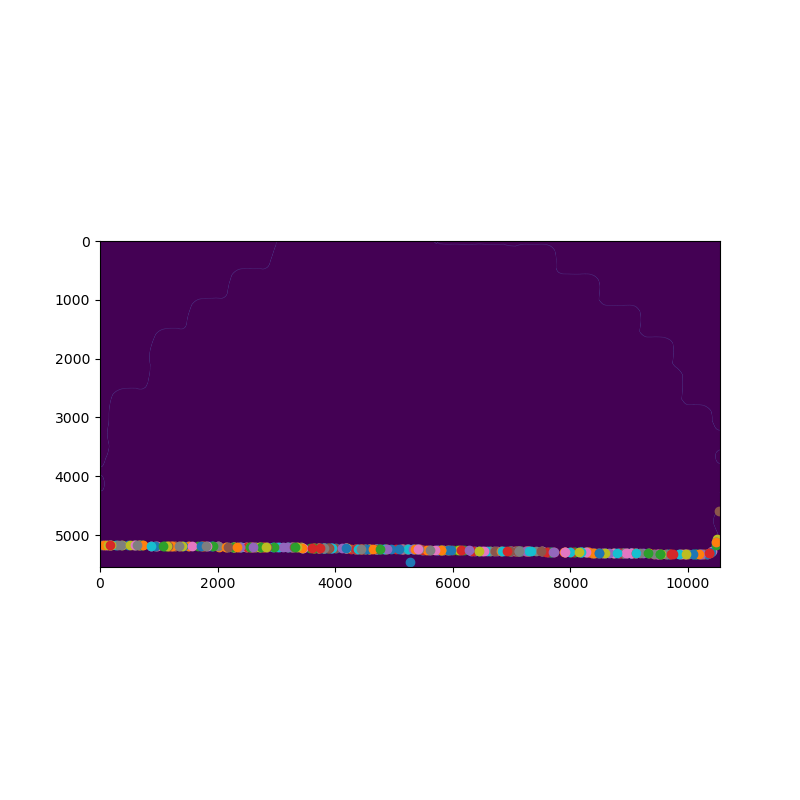

In [69]:
plt.close("all")
# fig=plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111)
im_modi = cv2.blur(im, (200, 200))
thresh = (im_modi < 60).astype(np.float64)
kernel1 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
identity = cv2.filter2D(src=thresh, ddepth=-1, kernel=kernel1)
# ax.imshow(im_modi<60)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(identity > 0)
num_point = 400
for point in [choice(border) for i in range(num_point)]:
    ax.scatter(point[1], point[0])
ax.scatter(xc_2, yc_2)

In [56]:
point

True

In [67]:
contour = identity > 0
x = 10
circle = []
border = []
for x in range(im.shape[1]):
    indexes = np.where(contour[:, x])[0]
    circle_y, border_y = indexes[0], indexes[-1]
    if circle_y < 4000:
        circle.append((circle_y, x))
    border.append((border_y, x))
x = np.array(circle)[:, 1]
y = np.array(circle)[:, 0]
x_m = np.mean(x)
y_m = np.mean(y)
method_2 = "leastsq"


def calc_R(xc, yc):
    """calculate the distance of each 2D points from the center (xc, yc)"""
    return np.sqrt((x - xc) ** 2 + (y - yc) ** 2)


def f_2(c):
    """calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc)"""
    Ri = calc_R(*c)
    return Ri - Ri.mean()


center_estimate = x_m, y_m
center_2, ier = optimize.leastsq(f_2, center_estimate)

xc_2, yc_2 = center_2
Ri_2 = calc_R(*center_2)
R_2 = Ri_2.mean()
residu_2 = sum((Ri_2 - R_2) ** 2)

In [68]:
xc_2, yc_2

(5280.428109520309, 5463.295237448539)

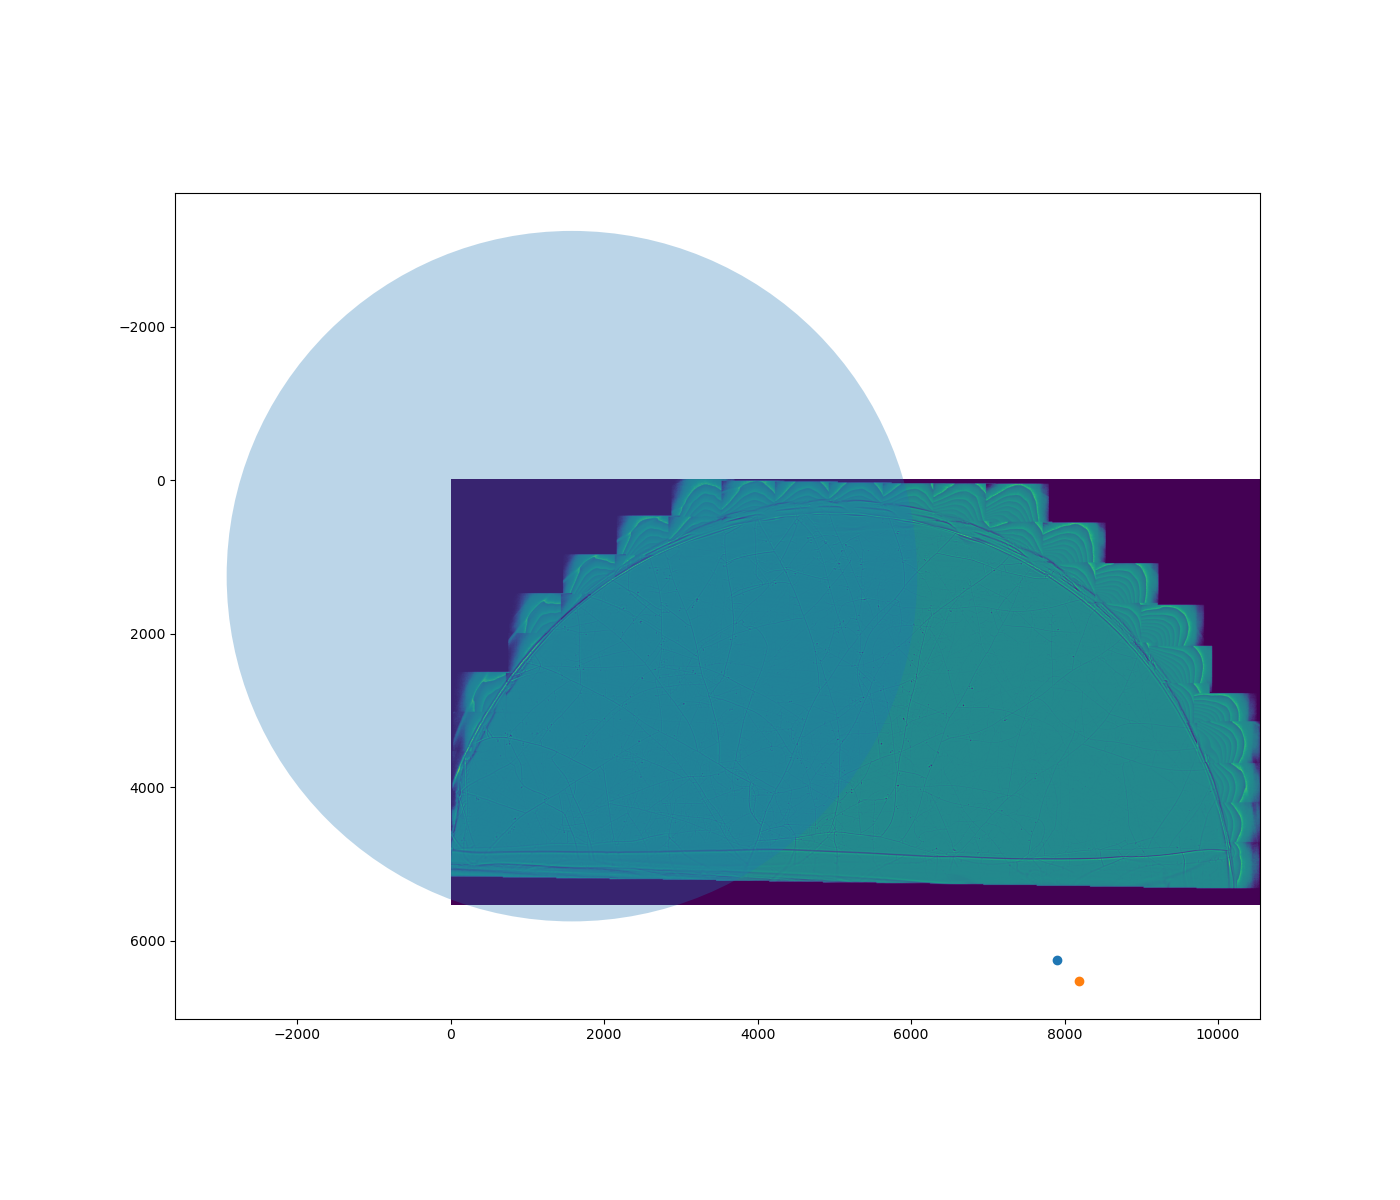

In [18]:
plt.close("all")
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111)
index = 0
y_c0, x_c0 = center
orthog = orth
orthog0 = orthog

circle2 = plt.Circle((y_c0 // 5, x_c0 // 5), 4500, alpha=0.3)
ax.add_patch(circle2)
ax.imshow(im)

ax.scatter(y_c0 + 0 * orthog0[1], x_c0 + 0 * orthog0[0])
ax.scatter(y_c0 + 400 * orthog0[1], x_c0 + 400 * orthog0[0])

In [6]:
def find_center_orth(directory, row):
    directory = directory_project
    directory_name = row["folder"]
    path_snap = directory + directory_name
    path_tile = path_snap + "/Img/TileConfiguration.txt.registered"
    try:
        tileconfig = pd.read_table(
            path_tile,
            sep=";",
            skiprows=4,
            header=None,
            converters={2: ast.literal_eval},
            skipinitialspace=True,
        )
    except:
        print("error_name")
        path_tile = path_snap + "/Img/TileConfiguration.registered.txt"
        tileconfig = pd.read_table(
            path_tile,
            sep=";",
            skiprows=4,
            header=None,
            converters={2: ast.literal_eval},
            skipinitialspace=True,
        )
    dirName = path_snap + "/Analysis"
    shape = (3000, 4096)
    try:
        os.mkdir(path_snap + "/Analysis")
        print("Directory ", dirName, " Created ")
    except FileExistsError:
        print("Directory ", dirName, " already exists")
    t = time()
    xs = [c[0] for c in tileconfig[2]]
    ys = [c[1] for c in tileconfig[2]]
    dim = (int(np.max(ys) - np.min(ys)) + 4096, int(np.max(xs) - np.min(xs)) + 4096)
    ims = []
    for name in tileconfig[0]:
        imname = "/Img/" + name.split("/")[-1]
        #     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
        ims.append(imageio.imread(directory + directory_name + imname))
    # contour = scipy.sparse.lil_matrix(dim,dtype=np.uint8)
    # half_circle = scipy.sparse.lil_matrix(dim,dtype=np.uint8)
    contour2 = scipy.sparse.lil_matrix((dim[0] // 5, dim[1] // 5), dtype=np.uint8)
    half_circle2 = scipy.sparse.lil_matrix((dim[0] // 5, dim[1] // 5), dtype=np.uint8)
    for index, im in enumerate(ims):
        im_cropped = im
        im_blurred = cv2.blur(im_cropped, (200, 200))
        im_back_rem = (im_cropped + 1) / (im_blurred + 1) * 120
        im_back_rem[im_back_rem >= 130] = 130
        boundaries = int(tileconfig[2][index][0] - np.min(xs)), int(
            tileconfig[2][index][1] - np.min(ys)
        )
        contour2[
            boundaries[1] // 5 : boundaries[1] // 5 + shape[0] // 5,
            boundaries[0] // 5 : boundaries[0] // 5 + shape[1] // 5,
        ] += cv2.resize(
            (im_blurred <= 20).astype(np.uint8), (im.shape[1] // 5, im.shape[0] // 5)
        )
    #     if index<=80:
    #         half_circle[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += points
    pivot = 3000
    circle = []
    border = []
    for x in range(2000, 8000):
        indexes = np.where(contour2[:, x].toarray() > 0)[0]
        distances = indexes - pivot
        X = list(indexes)
        Y = list(distances)
        sort_indexes = [x for _, x in sorted(zip(Y, X), key=lambda pair: 1 / pair[0])]
        candidates = sort_indexes[0], sort_indexes[-1]
        circle.append((x, min(candidates)))
        border.append((x, max(candidates)))
    array_circ = np.zeros(contour2.shape)
    array_bord = np.zeros(contour2.shape)
    for point in circle:
        array_circ[point[1], point[0]] = 1
    for point in border:
        array_bord[point[1], point[0]] = 1
    x = np.array(border)[:, 1]
    y = np.array(border)[:, 0].reshape(-1, 1)

    reg = LinearRegression().fit(y, x)
    orthog = [-1 / reg.coef_[0], 1]
    orthog = np.array(orthog) / np.linalg.norm(orthog)
    circle_correct = [point for point in circle if point[1] <= 3000]
    x = np.array(circle_correct)[:, 1]
    y = np.array(circle_correct)[:, 0]
    x_m = np.mean(x)
    y_m = np.mean(y)
    method_2 = "leastsq"

    def calc_R(xc, yc):
        """calculate the distance of each 2D points from the center (xc, yc)"""
        return np.sqrt((x - xc) ** 2 + (y - yc) ** 2)

    def f_2(c):
        """calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc)"""
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2 = calc_R(*center_2)
    R_2 = Ri_2.mean()
    residu_2 = sum((Ri_2 - R_2) ** 2)
    return ((xc_2, yc_2), orthog)

In [3]:
directory_project = "/projects/0/einf914/to_save/"
directory = directory_project
# index = 0
# plate = 38
# init = 0
# length = 50

In [6]:
todo_list = [
    (39, 269, 369),
    (40, 153, 190),
    (38, 7, 50),
    (38, 61, 105),
    (32, 160, 199),
    (39, 446, 486),
    (35, 70, 119),
    (38, 106, 130),
    (36, 204, 233),
    (30, 57, 94),
    (29, 221, 241),
    (40, 262, 312),
    (29, 160, 184),
    (30, 0, 24),
]

In [4]:
todo_list = [(38, 0, 58)]

In [5]:
for plate, init, end in todo_list:
    print(plate, init, end)
    (x_c, y_c), orthog = find_center_orth(plate, init)
    start = init
    finish = init
    dates_datetime = get_dates_datetime(directory, plate)
    dates_datetime_chosen = dates_datetime[start : finish + 1]
    dates = dates_datetime_chosen
    dilateds = []
    skels = []
    skel_docs = []
    directory_name = get_dirname(dates[0], plate)
    path_snap = directory + directory_name
    sio.savemat(
        path_snap + "/Analysis/mask_center_orthog.mat",
        {"center": (x_c, y_c), "orthog": orthog},
    )

38 0 58
Directory  /projects/0/einf914/to_save/20210818_1324_Plate38/Analysis  already exists


In [6]:
(x_c, y_c), orthog = find_center_orth(plate, init)

Directory  /projects/0/einf914/to_save/20210818_1324_Plate38/Analysis  already exists


In [9]:
itera = 1
kernel = np.ones((5, 5), np.uint8)
dates_datetime = get_dates_datetime(directory, plate)
dates_datetime_chosen = dates_datetime[0:1]
dates = dates_datetime_chosen
date = dates[0]
irectory_name = get_dirname(date, plate)
path_snap = directory + directory_name
skel_info = read_mat(path_snap + "/Analysis/skeleton_pruned_compressed.mat")
skel = skel_info["skeleton"]
skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]

In [39]:
start = init
finish = init
dates_datetime = get_dates_datetime(directory, plate)
dates_datetime_chosen = dates_datetime[start : finish + 1]
dates = dates_datetime_chosen
dilateds = []
skels = []
skel_docs = []
directory_name = get_dirname(dates[0], plate)
path_snap = directory + directory_name
sio.savemat(
    path_snap + "/Analysis/mask_center_orthog.mat",
    {"center": (x_c, y_c), "orthog": orthog},
)

In [13]:
x_c, y_c

(6028.3199245525375, 5567.7505433723145)

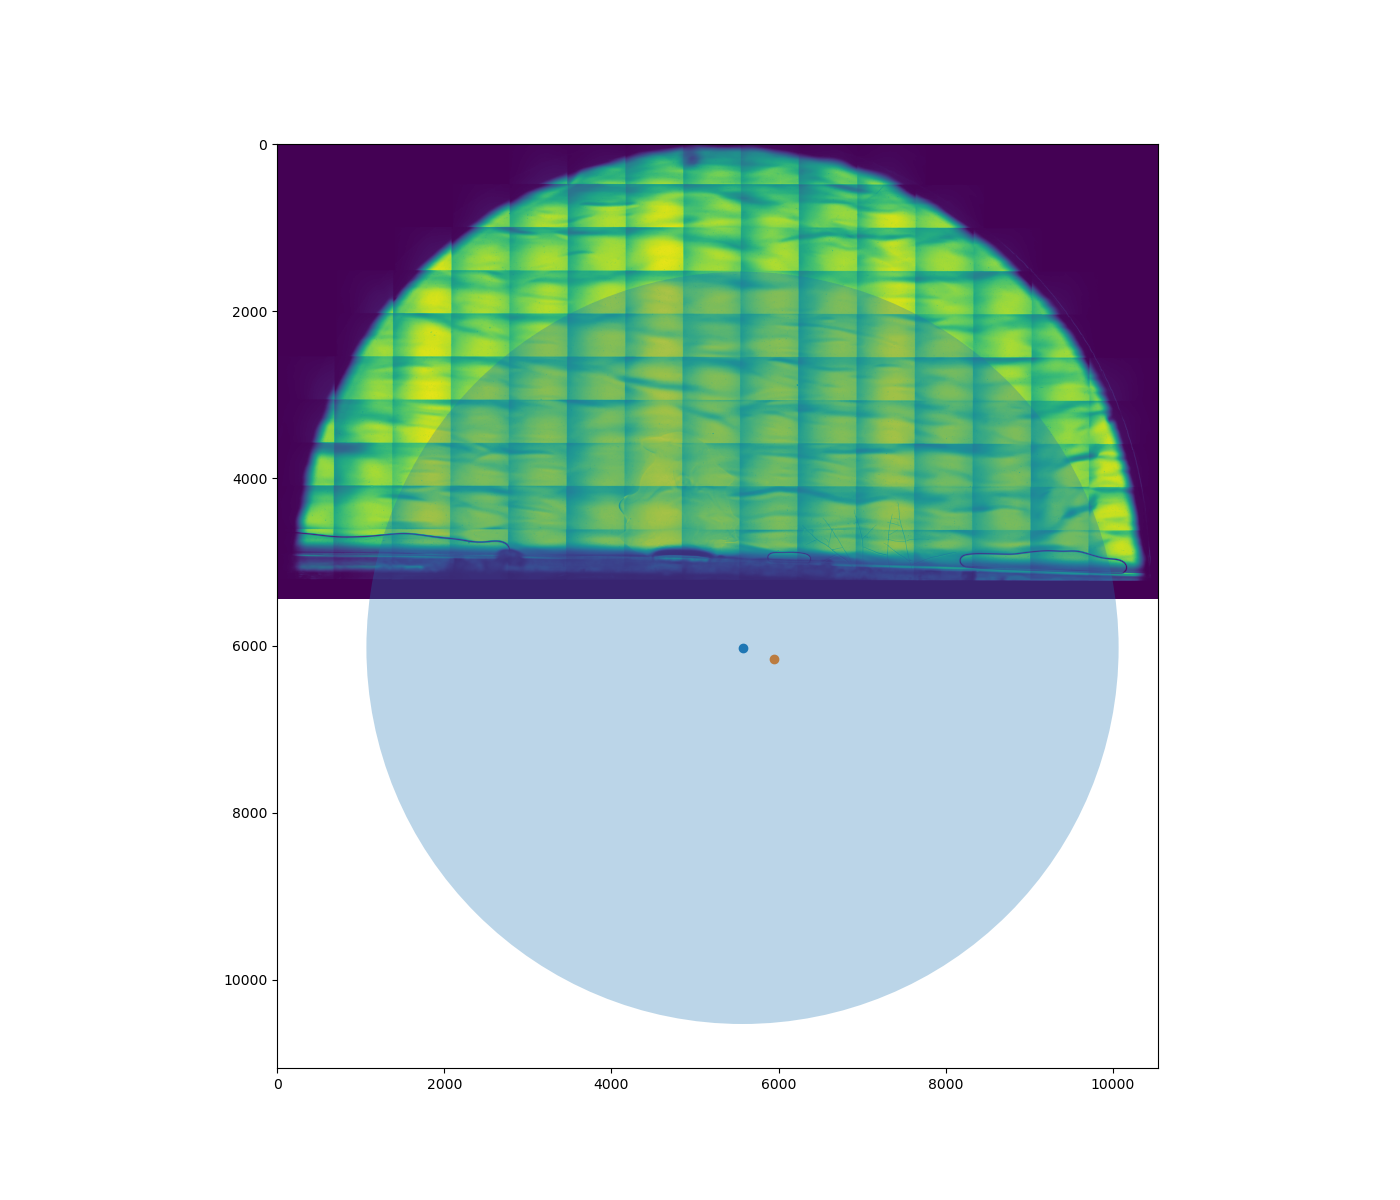

In [14]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111)
index = 0
y_c0, x_c0 = y_c, x_c
orthog0 = orthog

circle2 = plt.Circle((y_c0, x_c0), 4500, alpha=0.3)
ax.add_patch(circle2)
ax.imshow(im)

ax.scatter(y_c0 + 0 * orthog0[1], x_c0 + 0 * orthog0[0])
ax.scatter(y_c0 + 400 * orthog0[1], x_c0 + 400 * orthog0[0])

In [67]:
path_snap + "/Analysis/skeleton_realigned_compressed.mat"

'/projects/0/einf914/data/20201123_1601_Plate39/Analysis/skeleton_realigned_compressed.mat'

In [7]:
start = init
finish = init + 2
dates_datetime = get_dates_datetime(directory, plate)
dates_datetime_chosen = dates_datetime[start : finish + 1]
dates = dates_datetime_chosen
dilateds = []
skels = []
skel_docs = []
Rs = []
ts = []
for date in dates[1:]:
    directory_name = get_dirname(date, plate)
    path_snap = directory + directory_name
    skel_info = read_mat(path_snap + "/Analysis/skeleton.mat")
    skel = skel_info["skeleton"]
    skels.append(skel)
    skel_doc = sparse_to_doc(skel)
    skel_docs.append(skel_doc)
    transform = sio.loadmat(path_snap + "/Analysis/transform.mat")
    R, t = transform["R"], transform["t"]
    Rs.append(R)
    ts.append(t)

In [40]:
xcs = [x_c * 5]
ycs = [y_c * 5]
orthogs = [orthog]
R0 = np.array([[1, 0], [0, 1]])
t0 = np.array([0, 0])
for i, R in enumerate(Rs):
    #     print(i+begin,j)
    print(R0)
    R0 = np.dot(np.transpose(Rs[i]), R0)
    t0 = -np.dot(ts[i], np.transpose(Rs[i])) + np.dot(t0, np.transpose(Rs[i]))
    new_center = np.round(
        np.transpose(np.dot(R0, np.array([ycs[0], xcs[0]]))) + t0
    ).astype(np.int)
    new_orthog = np.transpose(
        np.dot(R0, np.transpose(np.array([orthog[1], orthog[0]])))
    )

    ycs.append(new_center[0][0])
    xcs.append(new_center[0][1])
    orthogs.append(np.array([new_orthog[1], new_orthog[0]]))

[[1 0]
 [0 1]]
[[ 0.99999432  0.00337148]
 [-0.00337148  0.99999432]]


In [16]:
(x_c, y_c), orthog

((5187.273537374353, 5072.936162342801), array([-0.99903997,  0.04380791]))

In [41]:
start = init + index
finish = init + index
dates_datetime = get_dates_datetime(directory, plate)
dates_datetime_chosen = dates_datetime[start : finish + 1]
dates = dates_datetime_chosen
skels = []
ims = []
kernel = np.ones((5, 5), np.uint8)
itera = 1
for date in dates:
    directory_name = get_dirname(date, plate)
    path_snap = directory + directory_name
    skel_info = read_mat(path_snap + "/Analysis/skeleton_pruned_compressed.mat")
    skel = skel_info["skeleton"]
    skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    ims.append(im)

In [42]:
plt.close("all")
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111)
index = 0
y_c0, x_c0 = xcs[index] // 5, ycs[index] // 5
orthog0 = orthogs[index]

circle2 = plt.Circle((y_c0, x_c0), 4500, alpha=0.3)
ax.add_patch(circle2)
ax.imshow(ims[0])

ax.scatter(y_c0 + 0 * orthog0[1], x_c0 + 0 * orthog0[0])
ax.scatter(y_c0 + 400 * orthog0[1], x_c0 + 400 * orthog0[0])
# index = 80
# y_c0,x_c0 = xcs[index]//5,ycs[index]//5
# orthog0 = orthogs[index]

# circle2 = plt.Circle((y_c0, x_c0),4500,alpha = 0.3)
# ax.add_patch(circle2)
# ax.imshow(ims2[0],alpha = 0.7)

# ax.scatter(y_c0+0*orthog0[1],x_c0+0*orthog0[0])
# ax.scatter(y_c0+400*orthog0[1],x_c0+400*orthog0[0])

/home/cbisot/anaconda3/envs/test/lib/python3.7/site-packages/matplotlib/__init__.py:880: MatplotlibDeprecationWarning: 
nbagg.transparent
  version, key, obj_type="rcparam", alternative=alt_key)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [56]:
start = init + 80
finish = init + 80
dates_datetime = get_dates_datetime(directory, plate)
dates_datetime_chosen = dates_datetime[start : finish + 1]
dates = dates_datetime_chosen
skels = []
ims2 = []
kernel = np.ones((5, 5), np.uint8)
itera = 1
for date in dates:
    directory_name = get_dirname(date, plate)
    path_snap = directory + directory_name
    skel_info = read_mat(path_snap + "/Analysis/skeleton_pruned_compressed.mat")
    skel = skel_info["skeleton"]
    skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    ims2.append(im)

In [58]:
xcs

[25936.367686871763,
 5135,
 5155,
 5199,
 5178,
 5165,
 5151,
 5193,
 5138,
 5184,
 5178,
 5127,
 5141,
 5145,
 5128,
 5128,
 5128,
 5136,
 5120,
 5120,
 5128,
 5170,
 5175,
 5121,
 5111,
 5124,
 5119,
 5126,
 5120,
 5119,
 5174,
 5119,
 5125,
 5167,
 5124,
 5149,
 5122,
 5124,
 5130,
 5096,
 5153,
 5169,
 5127,
 5173,
 5119,
 5122,
 5128,
 5123,
 5121,
 5137,
 5169,
 5128,
 5040,
 5170,
 5176,
 5153,
 5175,
 5159,
 5132,
 5175,
 5144,
 5126,
 5132,
 5141,
 5162,
 5118,
 5174,
 5163,
 5123,
 5158,
 5136,
 5177,
 5211,
 5160,
 5152,
 5195,
 5155,
 5195,
 5177,
 5154,
 5218,
 5175,
 5151,
 5146,
 5203,
 5162,
 5171,
 5162,
 5165,
 5160,
 5193,
 5176,
 5161,
 5168,
 5165,
 5169,
 5155,
 5160,
 5139,
 5151,
 5181]

In [45]:
i = 154
plate = 32
directory = directory_project

listdir = os.listdir(directory)
list_dir_interest = [
    name
    for name in listdir
    if name.split("_")[-1] == f'Plate{0 if plate<10 else ""}{plate}'
]
ss = [name.split("_")[0] for name in list_dir_interest]
ff = [name.split("_")[1] for name in list_dir_interest]
dates_datetime = [
    datetime(
        year=int(ss[i][:4]),
        month=int(ss[i][4:6]),
        day=int(ss[i][6:8]),
        hour=int(ff[i][0:2]),
        minute=int(ff[i][2:4]),
    )
    for i in range(len(list_dir_interest))
]
dates_datetime.sort()
dates_datetime_chosen = dates_datetime
dates = dates_datetime_chosen
date = dates[i]
directory_name = get_dirname(date, plate)
path_snap = directory + directory_name
path_tile = path_snap + "/Img/TileConfiguration.txt.registered"
try:
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
except:
    print("error_name")
    path_tile = path_snap + "/Img/TileConfiguration.registered.txt"
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
dirName = path_snap + "/Analysis"
shape = (3000, 4096)
try:
    os.mkdir(path_snap + "/Analysis")
    print("Directory ", dirName, " Created ")
except FileExistsError:
    print("Directory ", dirName, " already exists")
t = time()
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
dim = (int(np.max(ys) - np.min(ys)) + 4096, int(np.max(xs) - np.min(xs)) + 4096)
ims = []
for name in tileconfig[0]:
    imname = "/Img/" + name.split("/")[-1]
    #     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
    ims.append(imageio.imread(directory + directory_name + imname))
# contour = scipy.sparse.lil_matrix(dim,dtype=np.uint8)
# half_circle = scipy.sparse.lil_matrix(dim,dtype=np.uint8)
contour2 = scipy.sparse.lil_matrix((dim[0] // 5, dim[1] // 5), dtype=np.uint8)
half_circle2 = scipy.sparse.lil_matrix((dim[0] // 5, dim[1] // 5), dtype=np.uint8)
for index, im in enumerate(ims):
    print(index)
    im_cropped = im
    im_blurred = cv2.blur(im_cropped, (200, 200))
    im_back_rem = (im_cropped + 1) / (im_blurred + 1) * 120
    im_back_rem[im_back_rem >= 130] = 130
    #     laplacian = cv2.Laplacian((im_cropped<=15).astype(np.uint8),cv2.CV_64F)
    #     points = laplacian>=4
    #     np.save(f'Temp\dilated{tileconfig[0][i]}',dilated)
    boundaries = int(tileconfig[2][index][0] - np.min(xs)), int(
        tileconfig[2][index][1] - np.min(ys)
    )
    #     contour[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += points
    contour2[
        boundaries[1] // 5 : boundaries[1] // 5 + shape[0] // 5,
        boundaries[0] // 5 : boundaries[0] // 5 + shape[1] // 5,
    ] += cv2.resize(
        (im_blurred <= 20).astype(np.uint8), (im.shape[1] // 5, im.shape[0] // 5)
    )
#     if index<=80:
#         half_circle[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += points

Directory  /projects/0/einf914/data/20201224_1139_Plate32/Analysis  already exists
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [13]:
plt.close("all")
plot_t_tp1([], [], None, None, contour2.toarray(), contour2.toarray())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
pivot = 3000
circle = []
border = []
for x in range(2000, 8000):
    indexes = np.where(contour2[:, x].toarray() > 0)[0]
    distances = indexes - pivot
    X = list(indexes)
    Y = list(distances)
    sort_indexes = [x for _, x in sorted(zip(Y, X), key=lambda pair: 1 / pair[0])]
    candidates = sort_indexes[0], sort_indexes[-1]
    circle.append((x, min(candidates)))
    border.append((x, max(candidates)))

In [47]:
array_circ = np.zeros(contour2.shape)

In [48]:
array_bord = np.zeros(contour2.shape)

In [24]:
circle

[(2000, 1114),
 (2001, 1114),
 (2002, 1113),
 (2003, 1112),
 (2004, 1112),
 (2005, 1111),
 (2006, 1110),
 (2007, 1110),
 (2008, 1109),
 (2009, 1108),
 (2010, 1107),
 (2011, 1106),
 (2012, 1106),
 (2013, 1105),
 (2014, 1104),
 (2015, 1103),
 (2016, 1102),
 (2017, 1101),
 (2018, 1101),
 (2019, 1100),
 (2020, 1099),
 (2021, 1098),
 (2022, 1097),
 (2023, 1097),
 (2024, 1096),
 (2025, 1095),
 (2026, 1094),
 (2027, 1093),
 (2028, 1092),
 (2029, 1091),
 (2030, 1090),
 (2031, 1090),
 (2032, 1089),
 (2033, 1088),
 (2034, 1087),
 (2035, 1086),
 (2036, 1085),
 (2037, 1084),
 (2038, 1083),
 (2039, 1082),
 (2040, 1081),
 (2041, 1080),
 (2042, 1079),
 (2043, 1078),
 (2044, 1077),
 (2045, 1076),
 (2046, 1075),
 (2047, 1074),
 (2048, 1074),
 (2049, 1073),
 (2050, 1072),
 (2051, 1071),
 (2052, 1070),
 (2053, 1069),
 (2054, 1069),
 (2055, 1068),
 (2056, 1067),
 (2057, 1066),
 (2058, 1065),
 (2059, 1065),
 (2060, 1064),
 (2061, 1063),
 (2062, 1062),
 (2063, 1062),
 (2064, 1061),
 (2065, 1060),
 (2066, 10

In [49]:
for point in circle:
    if point[1] <= 3000:
        array_circ[point[1], point[0]] = 1
for point in border:
    if point[1] >= 3000:
        array_bord[point[1], point[0]] = 1

In [50]:
kernel = np.ones((11, 11), np.uint8)
dilation = cv2.dilate(array_circ.astype(np.uint8) * 255, kernel, iterations=1)
plt.close("all")
plot_t_tp1([], [], None, None, dilation, dilation)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [35]:
kernel = np.ones((11, 11), np.uint8)
dilation2 = cv2.dilate(array_bord.astype(np.uint8) * 255, kernel, iterations=1)
plt.close("all")
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111)
circle1 = plt.Circle((yc_2, xc_2), R_2, alpha=0.3)
circle2 = plt.Circle((yc_2, xc_2), 4500, alpha=0.3)
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.imshow(dilation + dilation2)
ax.scatter(yc_2 + 0 * orthog[1], xc_2 + 0 * orthog[0])
ax.scatter(yc_2 + 400 * orthog[1], xc_2 + 400 * orthog[0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
x = np.array(border)[:, 1]
y = np.array(border)[:, 0].reshape(-1, 1)

reg = LinearRegression().fit(y, x)
reg.score(y, x), reg.coef_, reg.intercept_

(0.003889488370766192, array([-0.01537462]), 4979.637099545567)

In [40]:
vec = [1, reg.coef_[0]]
orthog = [-1 / reg.coef_[0], 1]

In [61]:
orthog = np.array(orthog) / np.linalg.norm(orthog)

In [32]:
circle_correct = [point for point in circle if point[1] <= 3000]

In [33]:
x = np.array(circle_correct)[:, 1]
y = np.array(circle_correct)[:, 0]

In [34]:
x_m = np.mean(x)
y_m = np.mean(y)
method_2 = "leastsq"


def calc_R(xc, yc):
    """calculate the distance of each 2D points from the center (xc, yc)"""
    return np.sqrt((x - xc) ** 2 + (y - yc) ** 2)


def f_2(c):
    """calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc)"""
    Ri = calc_R(*c)
    return Ri - Ri.mean()


center_estimate = x_m, y_m
center_2, ier = optimize.leastsq(f_2, center_estimate)

xc_2, yc_2 = center_2
Ri_2 = calc_R(*center_2)
R_2 = Ri_2.mean()
residu_2 = sum((Ri_2 - R_2) ** 2)

In [21]:
R_2, xc_2, yc_2

(5079.8987782846, 5187.273537374353, 5072.936162342801)

In [12]:
compressed_contour = cv2.resize(contour.toarray(), (dim[1] // 5, dim[0] // 5))
compressed_circle = cv2.resize(contour.toarray(), (dim[1] // 5, dim[0] // 5))

In [20]:
kernel = np.ones((11, 11), np.uint8)
dilation = cv2.dilate(compressed_contour.astype(np.uint8) * 255, kernel, iterations=1)

In [14]:
contour2.shape

(5576, 10557)